In [1]:
import numpy as np
import math
from scipy.special import gamma
import pandas as pd
import matplotlib.pyplot as plt

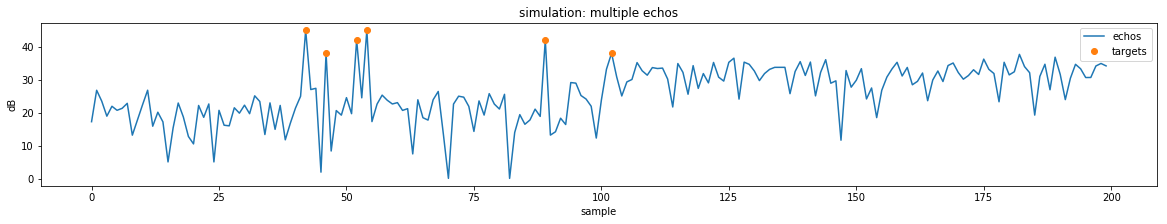

In [2]:
data = pd.read_csv('./resource/echo.csv')
echo = np.abs(data['signal'].values)
nData = len(echo)
t = np.array(range(0, nData))
echo_db = 10*np.log10(abs(echo))
x = np.array([42,46,52,54,89,102])

plt.rcParams['figure.figsize'] = [20, 3]
plt.plot(t, echo_db)
plt.title('simulation: multiple echos')

plt.plot(x,echo_db[x],'o')

plt.xlabel('sample')
plt.ylabel('dB')
plt.legend(['echos', 'targets'])

Text(0,0.5,'dB')

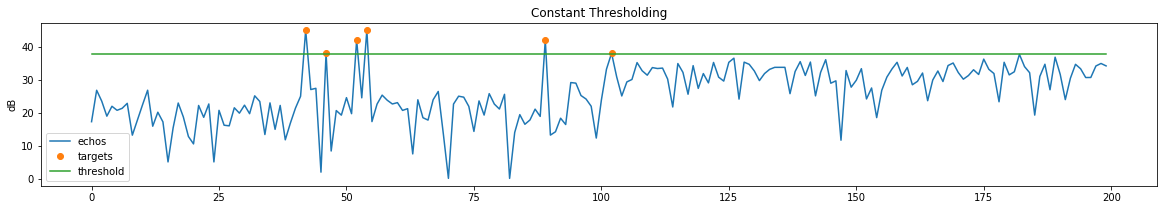

In [3]:
plt.rcParams['figure.figsize'] = [20, 3]
plt.plot(t, echo_db)
plt.title('Constant Thresholding')

plt.plot(x,echo_db[x], 'o')

thres = [37.9] * nData # magic threshold, 37.9
plt.plot(t, thres)
plt.legend(['echos', 'targets', 'threshold'])
plt.ylabel('dB')

# Constant Thresholding

### Pros & Cons Using constant threshold

|threshold|Probability of detection $P_d$|Probability of false alarm $P_{fa}$|
|-|-|
|Low|High|High|
|High|Low|Low|

Threshold is estimated from certain noise level
- Pro: Easy to implement
- Con: threshold may not be invalid, as noise level is time-variant

### Desired Detection Strategy
keep certain $P_{fa}$, e.g. 1e-3, then increase $P_d$.

$P_{fa}$ depends on system computation capability

### $P_{fa}$ estimation given Density Function of clutter signal $p(\mu)$
$P_f(u \geq U_T) = \int_{U_T}^{\infty} p(u) du$

# Self-Adaptation Thresholding
## Cell Averaging CFAR
![1D CFAR](./resource/CFARDetectionExample_01.png)
![2D CFAR](./resource/CFARDetectionExample_03.png)
- noise samples are extracted from both leading and lagging cells (called training cells) around the CUT, $P_n$ is noise power of CUT neighboring cells $P_n = \frac{1}{N} \sum_{i=1}^{N} x_i$
- Guard cells are placed adjacent to the CUT, both and leading and lagging it. The purpose of these guard cells is to avoid signal components from leaking into the training cell, which could adversely affect the noise estimate. **e.g., power leakage after Fourier Transform.**
- Cell under Test (CUT) is compared with detection threshold $T$, where $T = \alpha P_n$, $P_n$ is noise power of CUT neighboring cells, $\alpha$ is threshold factor, $\alpha=N (P_{fa}^{-\frac{1}{N}}-1)$ (only for signal pulse with white gussian noise)

In [12]:
def form_alpha_ca(pfa, N):
    # pfa: probability of false alarm
    # N: number of training cells
    n = math.floor(N / 2)
    alpha = n * ((pfa)**(-1/n) - 1)
    return alpha
def form_pfa_so(alpha, N):
    n = math.floor(N / 2)
    pfa = 0
    for i in range(0, n):
        pfa = pfa + 2 * gamma(n + i) / gamma(i + 1) / gamma(n) * (2 + alpha / n)**(-(n + i))
    return pfa
def form_pfa_go(alpha, N):
    n = math.floor(N / 2)
    pfa = 2 * (1 + alpha / n)**(-n)
    for i in range(0, n):
        pfa = pfa - 2 * gamma(n + i) / gamma(i + 1) / gamma(n) * (2 + alpha / n)**(-(n + i))
    return pfa
def form_pfa_os(alpha, N, percentile):
    k = math.ceil(N * percentile)
    pfa = gamma(N + 1) * gamma(N - k + alpha + 1) / gamma(N - k + 1) / gamma(N + alpha + 1)
    return pfa
def cfar(input_arr, alpha, nTrain, nGuard, option):
    foo = {'ca':np.mean, 'so':np.min, 'go':np.max}
    nElem = len(input_arr)
    target_arr = np.zeros(nElem)
    
    # create filter [0,0,0,0,0,0,1,1,1] and [1,1,1,0,0,0,0,0,0]
    train_cell = np.ones(nTrain)
    guard_cell = np.zeros(2 * nGuard + 1)
    filtL = np.concatenate((np.zeros(nTrain), guard_cell, train_cell)) / nTrain
    filtR = np.concatenate((train_cell, guard_cell, np.zeros(nTrain))) / nTrain

    # scan input_array
    convL = np.convolve(input_arr, filtL, 'same')
    convR = np.convolve(input_arr, filtR, 'same')
    conv = [convL, convR]
    avg_result = foo[option](conv, axis=0) # cell min
    target_arr = avg_result * alpha
    return target_arr
def cfar_os(input_arr, alpha, nTrain, nGuard, percentile):
    nElem = len(input_arr)
    target_arr = np.zeros(nElem)
    
    # scan input_array
    for i in range(nTrain + nGuard, nElem - nGuard - nTrain):
        trainL = input_arr[i - nTrain - nGuard : i - nGuard]
        trainR = input_arr[i + nGuard + 1: i + nGuard + nTrain + 1]
        train = np.concatenate((trainL, trainR))  
        train.sort()
        target_arr[i] = train[(int)(2 * nTrain * percentile)]
    for i in range(0, nTrain + nGuard):
        target_arr[i] = target_arr[nTrain + nGuard]
    for i in range(nElem - nGuard - nTrain, nElem):
        target_arr[i] = target_arr[nElem - nGuard - nTrain - 1]
    target_arr = target_arr * alpha
    return target_arr

In [5]:
# parameters
train_cell = 10
guard_cell = 1
pfa = 1e-3

threshold factor for (false alarm rate:0.001000, cell count:10) is 9.95

corresponding SNR = 9.98dB



Text(0.5,1,'detection result using CA-CFAR')

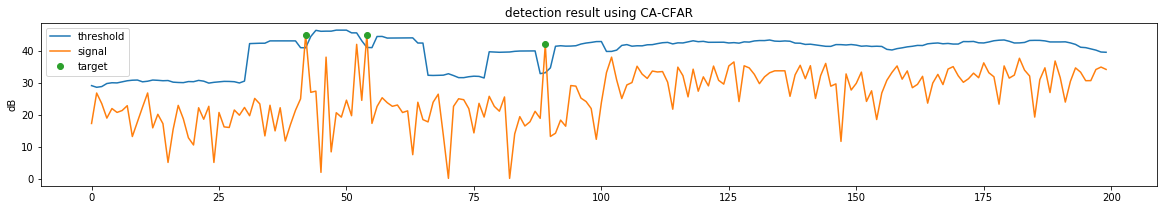

In [6]:
alpha = form_alpha_ca(pfa, 2 * train_cell)
print('threshold factor for (false alarm rate:%f, cell count:%d) is %.2f\n' %(1e-3, train_cell, alpha))
print('corresponding SNR = %.2fdB\n' %(10 * np.log10(alpha)))
thres_ca = cfar(echo, alpha, train_cell, guard_cell, 'ca')
thres_db = 10 * np.log10(thres_ca)
out = (echo > thres_ca)
idx = [i for i,x in enumerate(out) if x]

plt.plot(thres_db)
plt.plot(echo_db)
plt.plot(idx, echo_db[idx], 'o')
plt.ylabel('dB')
plt.legend(['threshold', 'signal', 'target'])
plt.title('detection result using CA-CFAR')

## Issues of CA-CFAR
- target shadowing effect
- clutter edge effect

### target shadowing effect
- The human body is a strong electromagnetic energy absorption object, which may cause directional shadowing effects on wireless signals.
- weak echo lies among strong echos

### clutter edge effect
- noise level sudden change, trigger false alarm

Text(0,0.5,'dB')

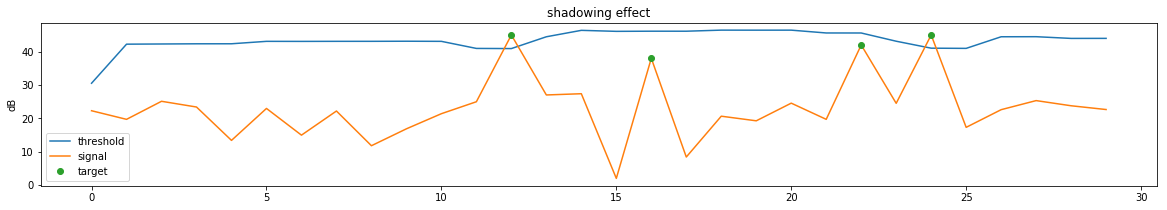

In [7]:
beg = 30
end = 60
plt.plot(thres_db[beg:end])
plt.plot(echo_db[beg:end])
plt.plot(x[0:4] - beg, echo_db[x[0:4]], 'o')
plt.legend(['threshold', 'signal', 'target'])
plt.title('shadowing effect')
plt.ylabel('dB')

## SO-CFAR: smallest of selection CFAR
- Pro: better on multiple target detection
- Con: worse on clutter edge

### alpha estimation
N: number of points

$P_{fa} = \sum_{i=0}^{N}\frac{2\Gamma(N+i)}{\Gamma(i+1) \Gamma(n)}(2+\frac{\alpha}{N})^{-(n+i)}, where\ \  \Gamma(x)=\int_{0}^{+\infty} t^{x-1} e^{-t} dt (x > 0)$

pfa=0.001012



/Users/sheldon/ml/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


Text(0.5,1,'detection result using SO-CFAR')

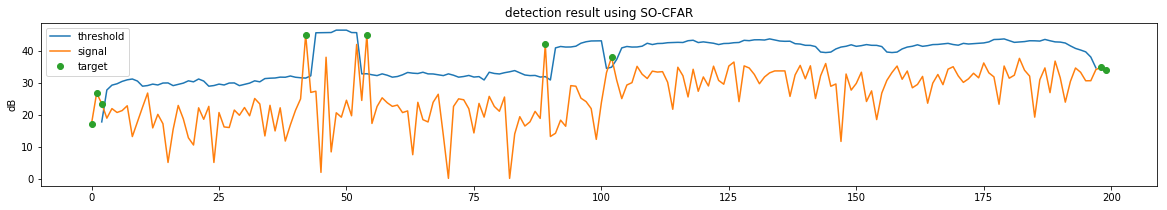

In [14]:
alpha = 11.25
print('pfa=%f\n' %form_pfa_so(alpha, 2 * train_cell))
thres_so = cfar(echo, alpha, train_cell, guard_cell, 'so')
thres_db = 10 * np.log10(thres_so)
out = (echo > thres_so)
idx = [i for i,x in enumerate(out) if x]

plt.plot(thres_db)
plt.plot(echo_db)
plt.plot(idx, echo_db[idx], 'o')
plt.ylabel('dB')
plt.legend(['threshold', 'signal', 'target'])
plt.title('detection result using SO-CFAR')

## GO-CFAR
- Pro: better on clutter edge 
- Con: worse on multiple target detection

### alpha estimation
N: number of points

$P_{fa} = \sum_{i=0}^{N}\frac{2\Gamma(N+i)}{\Gamma(i+1) \Gamma(n)}(2+\frac{\alpha}{N})^{-(n+i)} + 2\cdot(1+\frac{\alpha}{N})^{-N}, where\ \  \Gamma(x)=\int_{0}^{+\infty} t^{x-1} e^{-t} dt (x > 0)$

pfa=0.001032



Text(0.5,1,'detection result using GO-CFAR')

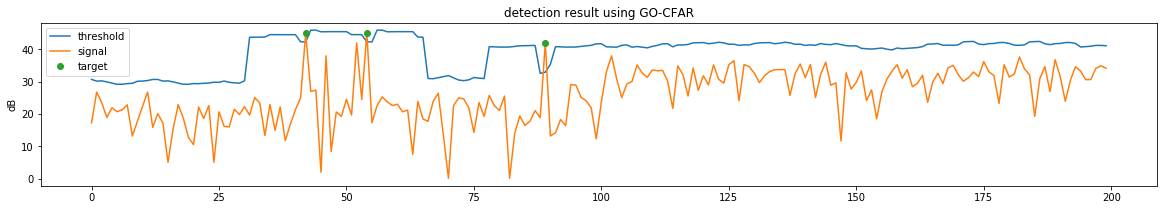

In [15]:
alpha = 7.2
print('pfa=%f\n' %form_pfa_go(alpha, 2 * train_cell))
thres_go = cfar(echo, alpha, train_cell, guard_cell, 'go')
thres_db = 10 * np.log10(thres_go)
out = (echo > thres_go)
idx = [i for i,x in enumerate(out) if x]

plt.plot(thres_db)
plt.plot(echo_db)
plt.plot(idx, echo_db[idx], 'o')
plt.ylabel('dB')
plt.legend(['threshold', 'signal', 'target'])
plt.title('detection result using GO-CFAR')

## OS-CFAR: Ordered-Statistic CFAR
- Pro: better on multiple target detection
- Con: worse on clutter edge

### alpha estimation
N: number of points

p: percentile, e.g. 0.5 means median

$p_{fa} = \frac{\Gamma(N+1) \Gamma(N-k+\alpha+1)}{\Gamma(N-k+1) \Gamma(N+\alpha+1)}, where \ \ \Gamma(x)=\int_{0}^{+\infty} t^{x-1} e^{-t} dt (x > 0), \ k=\lceil{N \cdot p}\rceil$

pfa=0.001006



Text(0.5,1,'detection result using OS-CFAR')

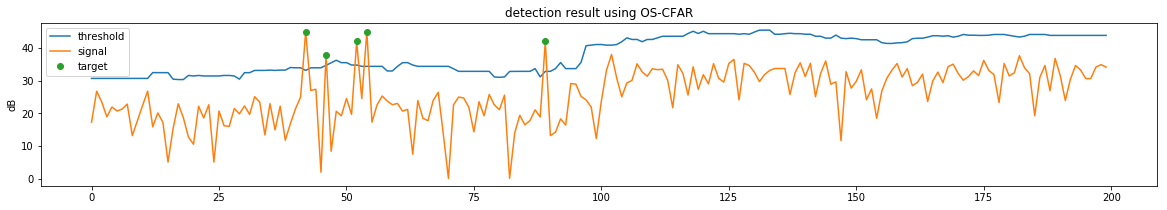

In [16]:
alpha = 15
percentile = 0.5
print('pfa=%f\n' %form_pfa_os(alpha, 2 * train_cell, percentile))
thres_os = cfar_os(echo, alpha, train_cell, guard_cell, percentile)
thres_db = 10 * np.log10(thres_os)
out = (echo > thres_os)
idx = [i for i,x in enumerate(out) if x]

plt.plot(thres_db)
plt.plot(echo_db)
plt.plot(idx, echo_db[idx], 'o')
plt.ylabel('dB')
plt.legend(['threshold', 'signal', 'target'])
plt.title('detection result using OS-CFAR')

/Users/sheldon/ml/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'comparisons of different CFAR strategy')

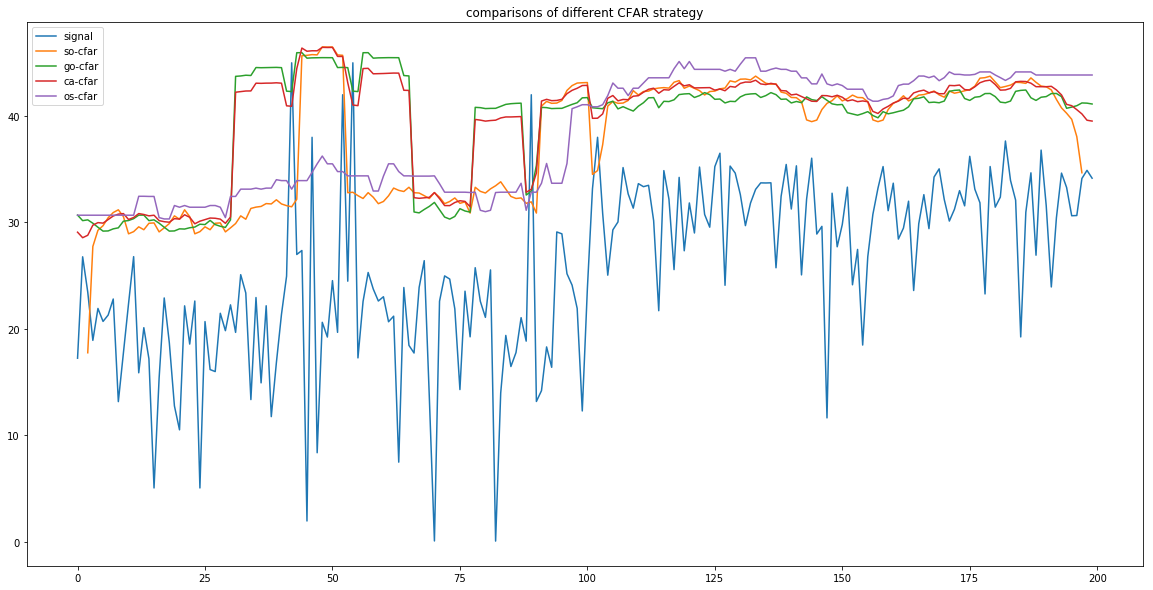

In [17]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(echo_db)
plt.plot(10 * np.log10(thres_so))
plt.plot(10 * np.log10(thres_go))
plt.plot(10 * np.log10(thres_ca))
plt.plot(10 * np.log10(thres_os))

plt.legend(('signal', 'so-cfar', 'go-cfar', 'ca-cfar', 'os-cfar'))
plt.title('comparisons of different CFAR strategy')

## Summary

- CA-CFAR: cell average CFAR
- SO-CFAR: smallest of selection CFAR
- GO-CFAR: greatest of selection CFAR
- OS-CFAR: Ordered-Statistic CFAR

|CFAR|multiple targets|clutter edge effect|
|-|-|-|
|CA_CFAR (baseline)|-|-|
|SO_CFAR|$\uparrow$|$\downarrow$|
|GO_CFAR|$\downarrow$|$\uparrow$|
|OS_CFAR|$\uparrow$|$\downarrow$|
![Averaging CFAR](./resource/ca-cfar.jpg)
![Sorted CFAR](./resource/os-cfar.png)
## references
- [Constant False Alarm Rate (CFAR) Detection
](https://www.mathworks.com/help/phased/examples/constant-false-alarm-rate-cfar-detection.html)
- [Signal Detection in White Gaussian Noise](https://www.mathworks.com/help/phased/examples/signal-detection-in-white-gaussian-noise.html)
- [Signal Detection Using Multiple Samples
](https://www.mathworks.com/help/phased/examples/signal-detection-using-multiple-samples.html)
- [雷达无线电系列（二）经典CFAR算法图文解析与实现（matlab）
](https://www.cnblogs.com/Mufasa/p/10900334.html)
- [雷达无线电系列（三）经典CFAR算法门限因子alpha计算（matlab）
](https://www.cnblogs.com/Mufasa/p/11950154.html)